# Randomized Benchmarking

Randomized benchmarking is a technique for determining the error of quantum gates on specific physical qubits of a QPU.

## Main Idea

To get the error of a gate on a qubit or qubit-connection, we can run sequences a growing number of $m$ random gates, where the entire gate sequence should result in the identity gate $I$.
<p align="center">
    <img src="docs/gate_sequence.png" alt="qv" width="300"/>
</p>

So, in the ideal case, we should measure the ground state $|0\rangle$ with probability $1$.

However, if we run such a circuit for increasing $m$ on a noisy QPU, we expect the probability of measuring the ground state to decay exponentially with $m$.Here, we run gate sequences on $n=2$ qubits:

<p align="center">
    <img src="docs/prob_decay.png" alt="qv" width="500"/>
</p>

We see, that for long gate sequences, the probability of measuring the ground state decays to $0.25$, which means that the measured state is completely mixed between the four ground states. This is because the noise of the QPU is accumulating over the gate sequence.

### Clifford Sequences

Since for long sequences it is hard to determine the inverse of the gate sequence with makes the entire sequence the identity, we use Clifford sequences. Clifford gates are easy to simulate and invert, and therefore we are able to efficiently construct large gate sequences which compute the identity.

<p align="center">
    <img src="docs/clifford_sequence.png" alt="qv" width="500"/>
</p>

Here, the gate $\mathcal{C_i}$ are random clifford gates, and the gate $\mathcal{C}_{m+1}$ is the inverse of the entire sequence $\mathcal{C}_1$ to $\mathcal{C}_m$.

/Users/nathanieltornow/rand_bench/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


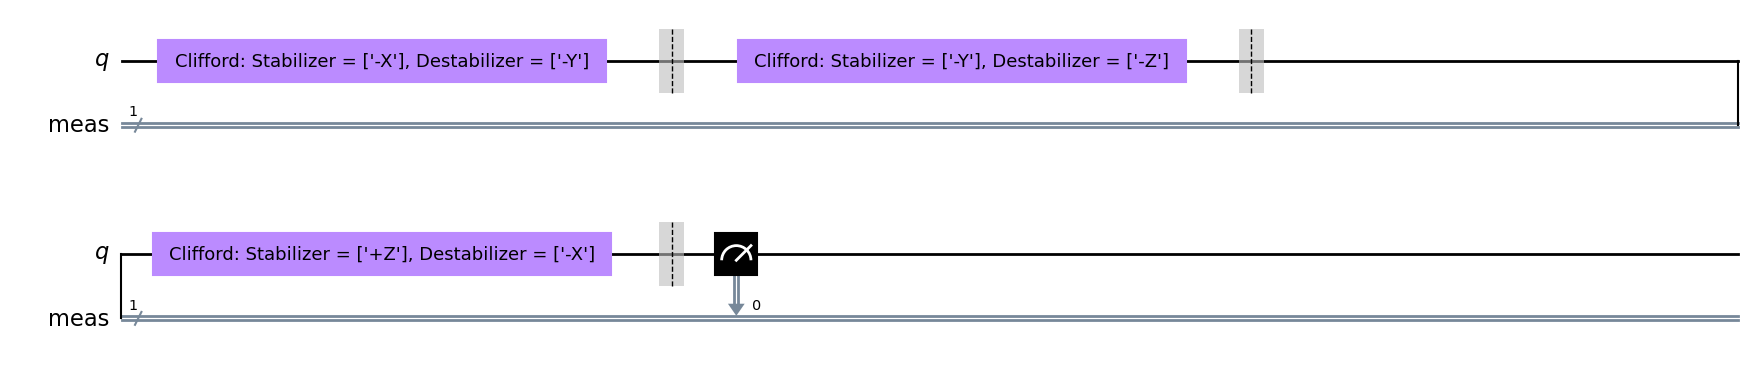

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})


from rb.rand_bench import generate_clifford_sequences, clifford_sequences_to_circuits

sequence_lengths = np.arange(2, 200, 20)

cliff_sequences = generate_clifford_sequences(1, sequence_lengths)

# the first sequence has 2 clifford gates, and one inverse gate
cliff_circuits = clifford_sequences_to_circuits(cliff_sequences, 1)
cliff_circuits[0].draw("mpl")

When we run the clifford sequences on a simulator, the probability of measuring the ground state is $1$ for all $m$.

In [2]:
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile

from rb.util import counts_to_probs

sim = AerSimulator()

cliff_circuits = transpile(cliff_circuits, sim)
probs = counts_to_probs(sim.run(cliff_circuits, shots=100).result().get_counts())
probs

[{'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0},
 {'0': 1.0}]

However, when we run the clifford sequences on noisy QPU with $n=2$ qubits, we see that the probability of measuring the ground state decays exponentially with $m$. For this we can use the `run_standard_rb()` function, which returns the probabilities of success for the different sequence lengths. Here, we measure the qubits 0 and 1 on the IBM Nairobi QPU.

In [3]:
from qiskit.providers.fake_provider import FakeNairobiV2
from rb.rand_bench import run_standard_rb, plot_rb_probs

qubits = [0]

nairobi_qpu = FakeNairobiV2()

rb_results = run_standard_rb(nairobi_qpu, qubits=qubits, sequence_lengths=np.arange(2, 3000, 400))
print(rb_results.mean_probs[:3])

[0.988 0.918 0.842]


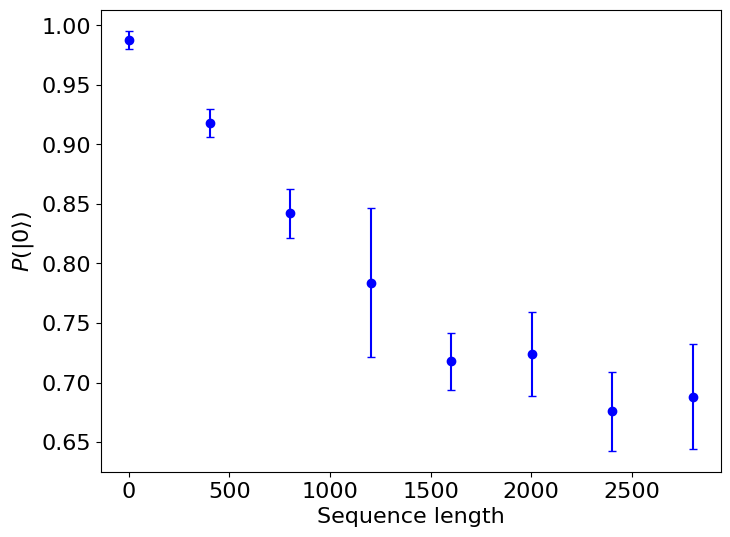

In [4]:
# plot the decay of the probability of success
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_rb_probs(ax, rb_results)
fig;

## Randomized Benchmarking Intuition

Now, we see the (exponential) decay in the probability of measuring the ground state, but how can we use this to determine the error of specific quantum gates?

For this, we need to look how the errors arise on the qubits. We can model the noise on the qubits as a depolarizing channel:

$$\rho_f = \alpha \rho_i + \frac{1-\alpha}{2^n} I$$

Here, $\rho_i$ is the initial state, $\rho_f$ is the final state. We see, that the noise is modeled as a mixture of the initial state and the completely mixed state $I$. The parameter $\alpha$ is the probability of the qubit to stay in the initial state, and with probability $1-\alpha$ the qubit is completely mixed.

Now, when we apply $m$ random clifford gates (each having the same average error $\alpha$) on the qubit, we get the following final state:

$$\rho_f = \alpha^m \rho_i + \frac{1-\alpha^m}{2^n} I$$

We see, that the probability of the qubit to stay in the initial state decays exponentially with $m$. The probability of success after the clifford sequence is therefore:

$$p(m) = \alpha^m + \frac{1-\alpha^m}{2^n}$$

which we can write as

$$p(m) = \frac{2^n - 1}{2^n} \alpha^m + \frac{1}{2^n} = A_0 \alpha^m + B_0$$

where $A_0$ can be considered as the state-preparation error, and $B_0$ as the measurement error. Now, the error per clifford-gate can be described as 

$$r = 1 - \left(\alpha + \frac{1 - \alpha}{2^n}\right)$$


To get this error, we need to find $\alpha$. For this, we do curve-fitting on $A_0 \alpha^m + B_0$, which describes the exponential decay of the probability of success.

alpha = 0.9992998085464455
Error per Clifford (EPC) = 0.0003500957267772442


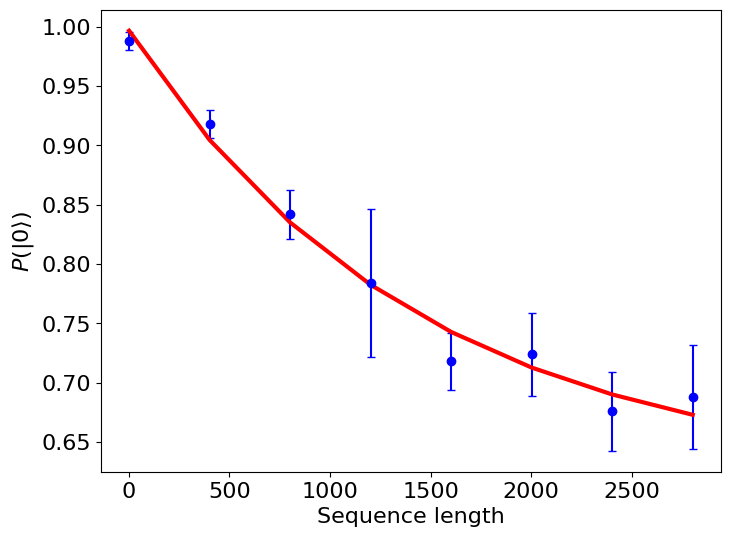

In [5]:
from scipy.optimize import curve_fit
from rb.rand_bench import plot_rb_fit


def fit_func(x, A0, alpha, B0):
    return A0 * alpha**x + B0

# some initial guesses for curve_fit
guesses = rb_results.mean_probs[0] - rb_results.mean_probs[-1], 0.99, rb_results.mean_probs[-1]

# fit the data to the curve
params, _ = curve_fit(fit_func, rb_results.sequence_lengths, rb_results.mean_probs, p0=guesses)

alpha = params[1]
print("alpha =", alpha)

epc = 1 - (alpha + (1 - alpha) / 2 ** (len(qubits)))
print("Error per Clifford (EPC) =", epc)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_rb_probs(ax, rb_results)
plot_rb_fit(ax, rb_results)
fig;

## Benchmarking an entire QPU

Now, we can use the randomized benchmarking to determine the error per clifford for an entire QPU. For this, we run the randomized benchmarking on each qubit and each qubit-connection of the QPU. The following picture shows the physical qubit layout of the IBM Nairobi QPU.

<p align="center">
    <img src="docs/layout.png" alt="qv" width="300"/>
</p>


In [6]:
from rb.rand_bench import benchmark_qpu_1q, benchmark_qpu_2q

errors_1q = benchmark_qpu_1q(nairobi_qpu)
errors_2q = benchmark_qpu_2q(nairobi_qpu)

Let's plot the error for each qubit and connection:

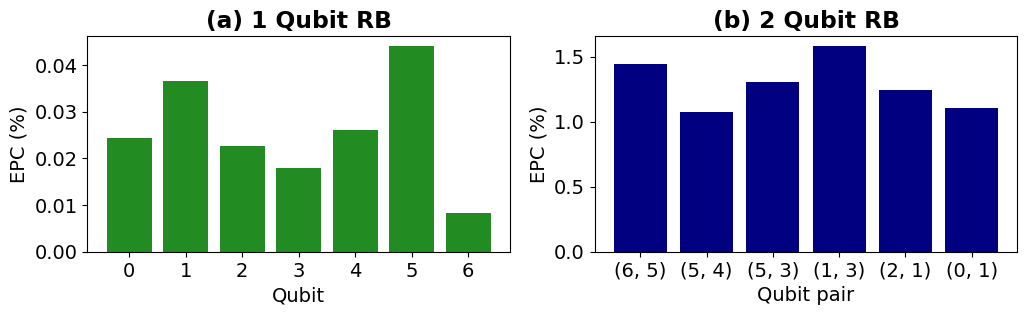

In [7]:
plt.rcParams.update({"font.size": 14})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2.8))


def plot_qpu_1q(ax: plt.Axes, errors: list[float]) -> None:
    ax.bar(range(len(errors)), errors, color="forestgreen")
    ax.set_xticks(range(len(errors)))
    ax.set_xticklabels(range(len(errors)))


def plot_qpu_2q(ax: plt.Axes, errors: dict[tuple[int, int], float]) -> None:
    ax.bar(range(len(errors)), errors.values(), color="navy")
    ax.set_xticks(range(len(errors)))
    ax.set_xticklabels(errors.keys())

plot_qpu_1q(ax1, errors_1q)
plot_qpu_2q(ax2, errors_2q)
ax1.set_ylabel("EPC (%)")
ax1.set_xlabel("Qubit")
ax1.set_title("(a) 1 Qubit RB", fontweight="bold")

ax2.set_title("(b) 2 Qubit RB", fontweight="bold")
ax2.set_ylabel("EPC (%)")
ax2.set_xlabel("Qubit pair")

fig;

## Interleaved Randomized Benchmarking

Through the randomized benchmarking protocol, we are able to derive the error of a random clifford gate on specific qubit(s). However, we were not able to derive the error of a specific gate, e.g., a $CNOT$ gate, that is native to the respective QPU.
For this, we can use the interleaved randomized benchmarking protocol. Here, in addition to the standard clifford sequences, we also run the same clifford sequences with the gate we want to benchmark interleaved. For example, if we want to benchmark the $CNOT$ gate, we run the following gate sequence:

<p align="center">
    <img src="docs/interleaved_sequence.png" alt="qv" width="500"/>
</p>

Now, we can run both sequences, and plot the decay of the probability of success:

In [8]:
from qiskit.circuit.library import CXGate
from rb.rand_bench import run_interleaved_rb

std_res, inter_res = run_interleaved_rb(nairobi_qpu, [5, 6], CXGate(), np.arange(2, 150, 20))

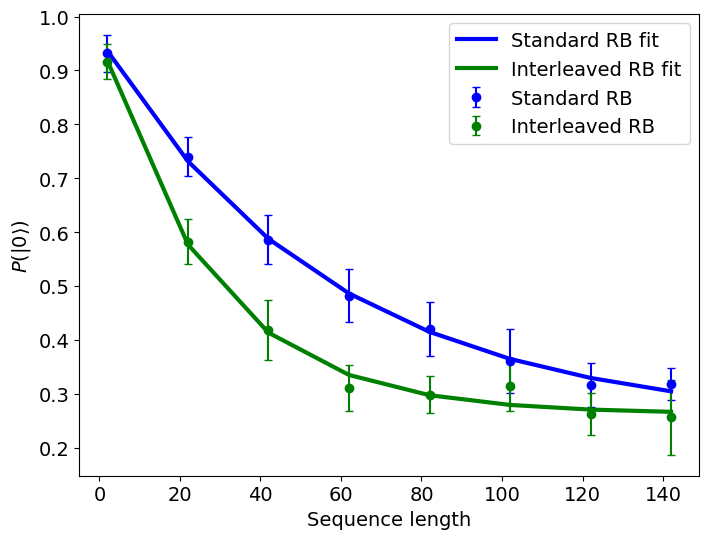

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_rb_probs(ax, std_res, label="Standard RB", color="blue")
plot_rb_probs(ax, inter_res, label="Interleaved RB", color="green")
plot_rb_fit(ax, std_res, color="blue", label="Standard RB fit")
plot_rb_fit(ax, inter_res, color="green", label="Interleaved RB fit")
ax.legend();

We see that the probability of success for the interleaved sequence decays faster than the standard sequence. This is because the interleaved sequence contains the gate we want to benchmark, which has an additional error.

To now get the error for the CX gate, we can derive the decay rates $\alpha_{std}$ and $\alpha_{int}$ for the standard and interleaved sequence, by using the exact same approach to the approach of the standard RB. The then define the relative decay rate as $\alpha_{rel} = \frac{a_{int}}{a_{std}}$.
To then get the error per gate, we use the following formula:

$$EPG_{CX} =  1 - \left(\alpha_{rel} + \frac{1 - \alpha_{rel}}{2^n}\right)$$

In [10]:
params_std, _ = curve_fit(fit_func, std_res.sequence_lengths, std_res.mean_probs, p0=guesses)
params_inter, _ = curve_fit(fit_func, inter_res.sequence_lengths, inter_res.mean_probs, p0=guesses)

alpha_std = params_std[1]
alpha_inter = params_inter[1]

alpha_rel = alpha_inter / alpha_std

epg = 1 - (alpha_rel + (1 - alpha_rel) / 2 ** (len(qubits)))
print("Error per CNOT gate =", epg)

Error per CNOT gate = 0.009493558144190395


Finally, lets us the interleaved randomized benchmarking to get the error per $H$ and $CNOT$ gate for the IBM Nairobi QPU:

In [11]:
from qiskit.circuit.library import HGate


errors_1q = benchmark_qpu_1q(nairobi_qpu, HGate())
errors_2q = benchmark_qpu_2q(nairobi_qpu, CXGate())

0.032896652680071616


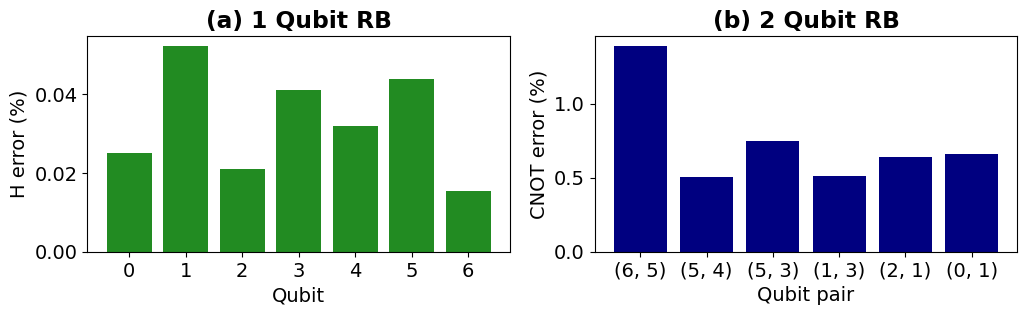

In [12]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2.8))

plot_qpu_1q(ax1, errors_1q)
plot_qpu_2q(ax2, errors_2q)
ax1.set_ylabel("H error (%)")
ax1.set_xlabel("Qubit")
ax1.set_title("(a) 1 Qubit RB", fontweight="bold")

print(np.average(errors_1q))

ax2.set_title("(b) 2 Qubit RB", fontweight="bold")
ax2.set_ylabel("CNOT error (%)")
ax2.set_xlabel("Qubit pair")

fig;

Finally, we can compare our results with the calibration data of the QPU:

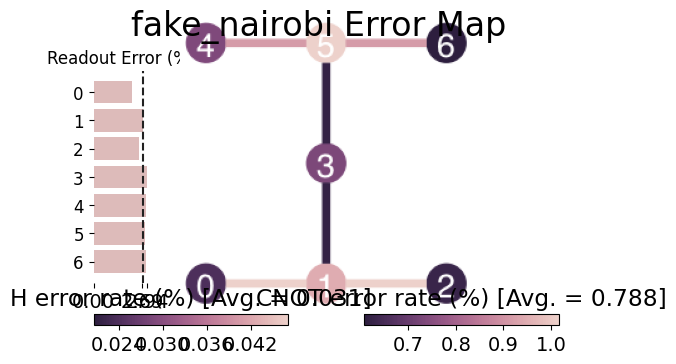

In [13]:
from qiskit.visualization import plot_error_map

plot_error_map(nairobi_qpu, figsize=(6, 4))